# **ALFA dataset Anomaly Classificataion using Mcfly module reference, using SImple CNN Window size 60**

**Anomaly Classification using CNN**

<!-- ## **Setup Dependencies** -->

In [48]:
import os
import sys
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from collections import Counter
# from sktime.datatypes import convert_to
from timeit import default_timer as timer
#from sktime.datasets import load_from_tsfile
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#from sktime.datasets import load_from_tsfile_to_dataframe
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# from mcfly.modelgen import generate_models
# from mcfly.find_architecture import find_best_architecture
# from mcfly.find_architecture import train_models_on_samples
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import torch

warnings.filterwarnings('ignore')
np.random.seed(42)

## **Load Dataset**

The given size (N, seq_len, features) applicable for mcfly

In [70]:
# no rolling stats
X = np.load('/kaggle/input/alfa-seq-windows-60-v3/ALFA_seq_windows_60/alfa_dataset_complete_sequence_X_windows_60.npy')
y = np.load('/kaggle/input/alfa-seq-windows-60-v3/ALFA_seq_windows_60/alfa_dataset_complete_sequence_y_windows_60.npy')
print(X.shape)
print(y.shape)

(3604, 60, 17)
(3604,)


**Swapaxes, output shape (N,features,seq_len), its required for pytorch**

In [69]:
X = np.swapaxes(X, 1, 2)
X.shape

(3604, 17, 60)

#### **Z-score normalize**

In [71]:
mean = np.mean(X, axis=(0,2), keepdims=True)
std = np.std(X, axis=(0, 2), keepdims=True)
X_norm = (X - mean) / std
print(X_norm.shape)

(3604, 60, 17)


**Label encoding**

Applicable for mcfly only

In [72]:
ohe = OneHotEncoder()

y = ohe.fit_transform(y.reshape(-1, 1)).toarray()
y.shape

(3604, 5)

## **Train valid test split**

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.10, random_state=42,
                                                    shuffle=True, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.10, random_state=42,
                                                  shuffle=True, stratify=y_train)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(2918, 60, 17) (325, 60, 17) (361, 60, 17)
(2918, 5) (325, 5) (361, 5)


#### **Class weights**

In [74]:
class_weights = compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(np.argmax(y, axis=1)),
    y = np.argmax(y, axis=1)
)

class_weights = dict(zip(np.unique(np.argmax(y, axis=1)), class_weights))
class_weights

{0: 0.29253246753246753,
 1: 6.612844036697248,
 2: 2.0892753623188405,
 3: 2.0892753623188405,
 4: 2.113782991202346}

## **SImple CNN for TimeSeries Windows 60**

In [75]:
%%time

file_name = f"model-comparison-20220808.json"
output_file = os.path.join("/kaggle/working/", file_name)
model_path = os.path.join("/kaggle/working/")

metric_key = "pr_auc"
metric = AUC(curve="PR", name=metric_key )

# metric_key = "accuracy"
# metric = "accuracy"

models = generate_models(
    X_train.shape,
    y_train.shape[1],
    number_of_models=3,
    model_types=['CNN'],
    metrics=[metric]
)

history, val_metrics, val_losses = train_models_on_samples(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    models=models,
    nr_epochs=30,
    verbose=True,
    model_path=model_path,
    outputfile=output_file,
    subset_size=int(X_train.shape[0] / 2),
    class_weight=class_weights
)

Generated models will be trained on subset of the data (subset size: 1459).
Training model 0 CNN
Epoch 1/30
73/73 [==============================] - 12s 33ms/step - loss: 2.9965 - pr_auc: 0.2601 - val_loss: 2.8424 - val_pr_auc: 0.3075
Epoch 2/30
73/73 [==============================] - 1s 16ms/step - loss: 2.3252 - pr_auc: 0.3596 - val_loss: 2.5729 - val_pr_auc: 0.3837
Epoch 3/30
73/73 [==============================] - 1s 16ms/step - loss: 1.8708 - pr_auc: 0.4491 - val_loss: 2.8163 - val_pr_auc: 0.3082
Epoch 4/30
73/73 [==============================] - 1s 16ms/step - loss: 1.5578 - pr_auc: 0.5225 - val_loss: 2.2773 - val_pr_auc: 0.4040
Epoch 5/30
73/73 [==============================] - 1s 16ms/step - loss: 1.3687 - pr_auc: 0.5807 - val_loss: 2.0949 - val_pr_auc: 0.4646
Epoch 6/30
73/73 [==============================] - 1s 16ms/step - loss: 1.3149 - pr_auc: 0.6035 - val_loss: 1.9313 - val_pr_auc: 0.5314
Epoch 7/30
73/73 [==============================] - 1s 16ms/step - loss: 1.2344 

**Finding Best Model**

In [76]:
best_model_index = np.argmax(val_metrics[metric_key])
best_model, best_params, best_model_type = models[best_model_index]

print(best_model_index)
print("Best model type:", best_model_type)

2
Best model type: CNN


**Sample Models Comparison**

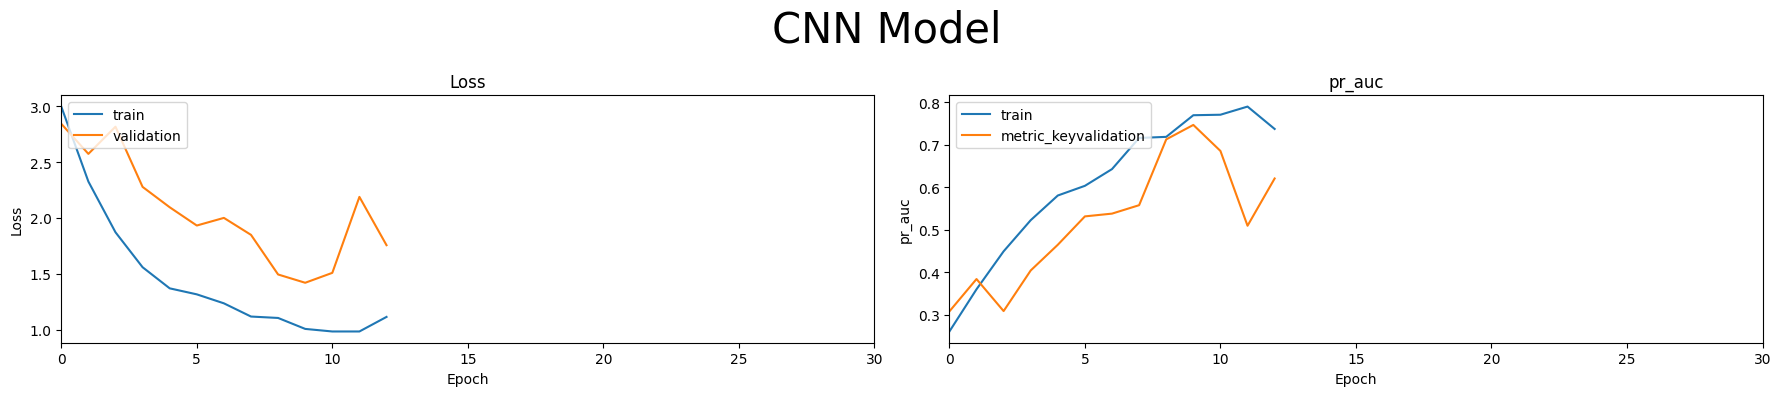

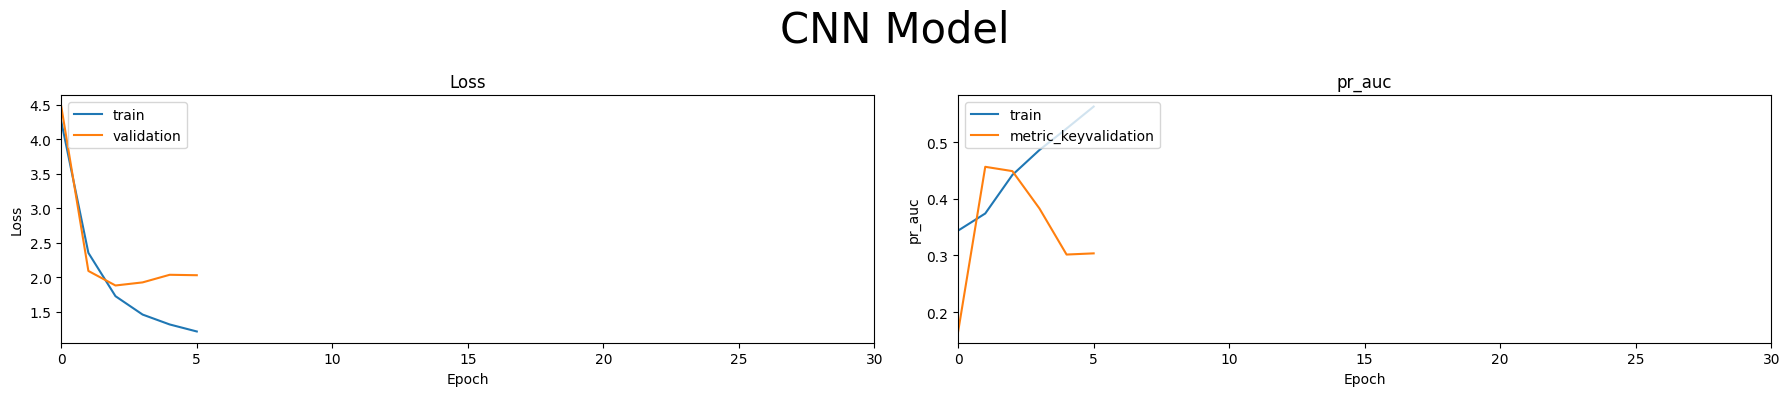

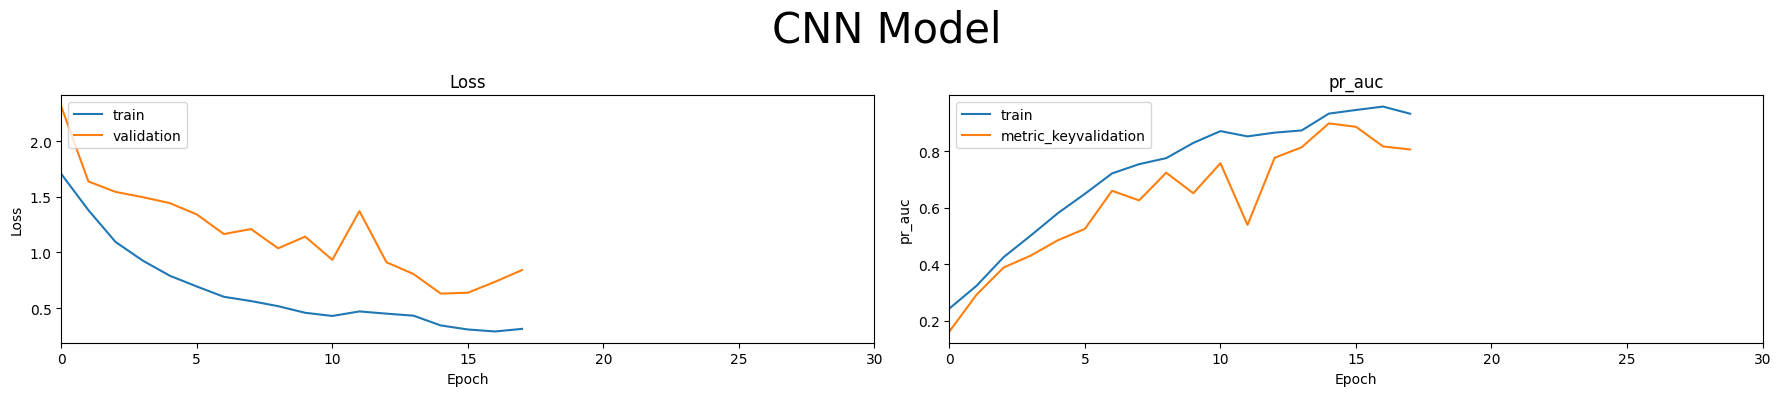

In [77]:
model_types = list(map(lambda m: m[2],models))

for i in range(len(model_types)):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18, 4))

    fig.suptitle(f"{model_types[i]} Model", fontsize=30)

    ax1.plot(history[i].history['loss'])
    ax1.plot(history[i].history['val_loss'])
    ax1.set_title('Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_xlim([0, 30])
    ax1.legend(['train', 'validation'], loc='upper left')

    ax2.plot(history[i].history[metric_key])
    ax2.plot(history[i].history[f'val_{metric_key}'])
    ax2.set_title(metric_key)
    ax2.set_ylabel(metric_key)
    ax2.set_xlabel('Epoch')
    ax2.set_xlim([0, 30])
    ax2.legend(['train', 'metric_keyvalidation'], loc='upper left')

    plt.tight_layout()
    plt.show()

#### **Training**

**Defined Training Metadata**

In [78]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint_path = 'best_model.h5'

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)


history = best_model.fit(
    X_train,
    y_train,
    epochs=100,
    callbacks=[early_stopping, checkpoint_callback],
    validation_data=(X_val, y_val),
)

Epoch 1/100
92/92 [==============================] - ETA: 0s - loss: 0.6243 - pr_auc: 0.8861
Epoch 1: val_loss improved from inf to 0.57811, saving model to best_model.h5
92/92 [==============================] - 4s 20ms/step - loss: 0.6243 - pr_auc: 0.8861 - val_loss: 0.5781 - val_pr_auc: 0.9325
Epoch 2/100
91/92 [============================>.] - ETA: 0s - loss: 0.5294 - pr_auc: 0.9325
Epoch 2: val_loss improved from 0.57811 to 0.42307, saving model to best_model.h5
92/92 [==============================] - 1s 13ms/step - loss: 0.5305 - pr_auc: 0.9321 - val_loss: 0.4231 - val_pr_auc: 0.9760
Epoch 3/100
90/92 [============================>.] - ETA: 0s - loss: 0.4843 - pr_auc: 0.9449
Epoch 3: val_loss improved from 0.42307 to 0.34033, saving model to best_model.h5
92/92 [==============================] - 1s 13ms/step - loss: 0.4845 - pr_auc: 0.9452 - val_loss: 0.3403 - val_pr_auc: 0.9807
Epoch 4/100
91/92 [============================>.] - ETA: 0s - loss: 0.4606 - pr_auc: 0.9545
Epoch 4:

**In case loading from best model**

In [84]:
# load the best checkpoint model
from keras.models import load_model
best_model = load_model('/kaggle/working/model_2.h5')
#model.summary()

#### **Evaluation**

**Predict**

In [79]:
import time

t = time.time()
y_pred = best_model.predict(X_test, batch_size=1)
print(time.time() - t)

361/361 [==============================] - 1s 2ms/step
20.248385667800903


**Classification Matrix**

In [80]:
print(f"Classification report fot the CNN model:\n")
print(
    classification_report(
        np.argmax(y_test, axis=1),
        np.argmax(y_pred, axis=1),
        digits=4
    )
)

Classification report fot the CNN model:

              precision    recall  f1-score   support

           0     0.9839    0.9879    0.9859       247
           1     1.0000    0.5455    0.7059        11
           2     0.8718    1.0000    0.9315        34
           3     0.9697    0.9143    0.9412        35
           4     0.9429    0.9706    0.9565        34

    accuracy                         0.9668       361
   macro avg     0.9536    0.8836    0.9042       361
weighted avg     0.9686    0.9668    0.9651       361



#### **Confusion Matrix**

Classification report fot the Inception model:

              precision    recall  f1-score   support

           0     1.0000    0.9731    0.9864       260
           1     1.0000    1.0000    1.0000        20
           2     0.7241    0.9130    0.8077        23
           3     0.8333    0.8696    0.8511        23
           4     0.9565    0.9565    0.9565        23

    accuracy                         0.9628       349
   macro avg     0.9028    0.9424    0.9203       349
weighted avg     0.9680    0.9628    0.9645       349



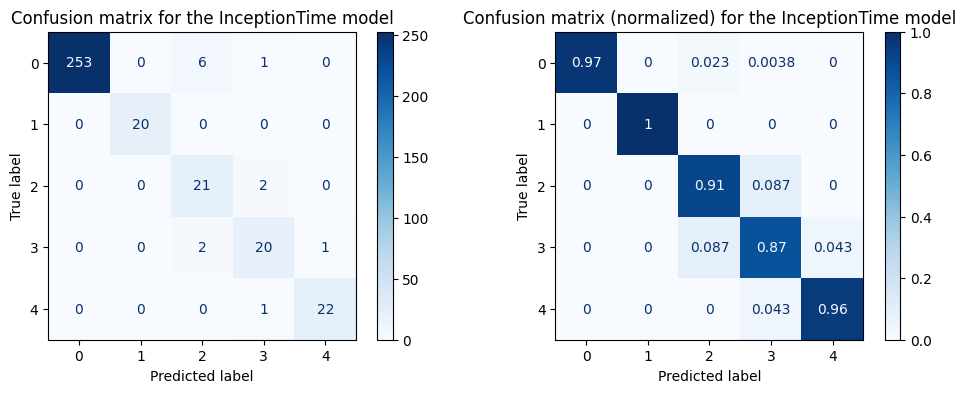

In [72]:
print(f"Classification report fot the Inception model:\n")
print(
    classification_report(
        np.argmax(y_test, axis=1),
        np.argmax(y_pred, axis=1),
        digits=4
    )
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1),
    display_labels=list(ohe.categories_[0]),
    normalize=None,
    cmap="Blues",
    ax=ax1
)

ax1.set_title(f"Confusion matrix for the {best_model_type} model")

ConfusionMatrixDisplay.from_predictions(
    np.argmax(y_test, axis=1),
    np.argmax(y_pred, axis=1),
    display_labels=list(ohe.categories_[0]),
    normalize="true",
    cmap="Blues",
    ax=ax2
)

ax2.set_title(f"Confusion matrix (normalized) for the {best_model_type} model")
plt.show()

## **Zipping**

In [79]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'directory.zip'):
    """
    zip all the files in a directory
    
    Parameters
    ___
    directory: str
        directory needs to be zipped, defualt is current working directory
        
    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'
        
    Returns
    ___
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

In [80]:
zip_dir(file_name = 'ALFA_experiment_jul_21_acc_99_windows_60_Inception_Spatial_GradCam.zip')

/kaggle/working/ALFA_experiment_jul_21_acc_99_windows_60_Inception_Spatial_GradCam.zip

--THE END--